<a href="https://colab.research.google.com/github/philip-pearce/randomwalkers/blob/main/random_walkers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

In this mini-project, we model the diffusion of random walkers using discrete and continuum methods, and compare the solutions.

# **Background**

Consider the motion of particles along one axis. The particles start at
time $t=0$ at position $x=0$ and execute a random walk according to the
following rules:

*   Each particle steps to the right or the left once every $\tau$ seconds, moving a distance $dx_i=\pm \delta$.
*   The probability of going to the right at each step is 1/2, and the
probability of going to the left is 1/2, independently of the previous history.
*   Each particle moves independently of all the other particles,
i.e. the particles do not interact with one another.
*   Particle moves do not depend on the history.

At a continuum level, the number density $n$ of these particles can be shown to satisfy the diffusion equation:

\begin{equation}
\frac{\partial n}{\partial t}=D\frac{\partial^2 n}{\partial x^2}.
\end{equation}

In the code below, we simulate random walkers and compare their locations to analytical and numerical solutions of the diffusion equation.

# **Activities**
In general, think about the comparitive benefits and drawbacks of the discrete and continuum models in either representing a real biological system or in testing the implications of model assumptions. You do not have to complete these activities in order; you could also do some wider reading and explore other ideas, building from this code or writing new code.

1. Inspect and run the code below, and inspect the output. Try to understand how to change parameters and how they affect the solutions.
2. Show that the expected value of the mean-squared displacement of the walkers behaves as predicted by the theory.
3. What happens in each model if you allow the walkers to stay in the same place with equal likelihood as moving?
4. Can you add a uniform drift to the random walker simulation, so that they are more likely to move right than left? How does this affect the continuum equation and analytical solution, and the numerical method for solving the continuum equation (e.g. best discretisation)?
5. Can you extend the model(s) to higher dimensions?
6. Investigate random walkers that interact, or proliferate, or chemotact towards chemicals; or look up a biological system that has been modelled using random walkers and see if you can recreate the findings.

# **Code**

First, we simulate 1000 random walkers and compare the histogram of their locations to the analytical solution of the diffusion equation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
from IPython import display
from time import sleep

#set parameters
num_particles = 1000;
num_timesteps = 20;
timestep = 1;
starting_position = 0;
move_dist = 1;
N=500;
#directions that the particle can move: left or right
possible_directions = np.array([-1,1]);

#initialise position vector
position = np.zeros((num_timesteps,num_particles));
for j in range(0,num_particles):
  position[0,j] = starting_position;

#randomly sample the move direction for all timesteps
move_directions = np.random.choice(a = possible_directions,size = [num_timesteps,num_particles])

#loop over timepoints for each particle and solve for position based on movement
for j in range(0,num_particles):
  for i in range(1,num_timesteps):
    position[i,j] = position[i-1,j] + move_dist*move_directions[i,j]


Now that we've performed the simulation, we can analyse the results and check that they behave as expected based on theory. For example, we can check that the number density looks similar in comparison to the analytical solution of the diffusion equation.

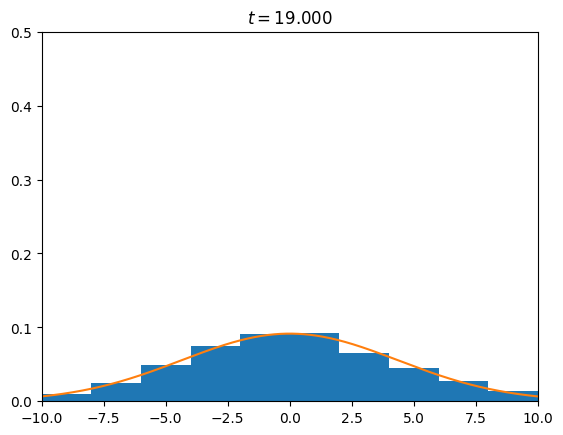

In [3]:
#Plotting - for a more elegant implementation see also https://matplotlib.org/stable/gallery/animation/random_walk.html
bins = np.linspace(-20, 20, 21)
fig, ax = plt.subplots()
xlimit = [-10,10]
ylimit = [0,0.5]

#Calculate analytical solution - note diffusion coefficient D=1/2 in this case because tau=1, delta=1
#Also note that at t=0, y is technically a delta function which we do not plot
x = np.linspace(xlimit[0],xlimit[1],N)
y = np.zeros((num_timesteps,np.shape(x)[0]))

D=1/2
for i in range(1,num_timesteps):
  t = i * timestep;
  y[i,:] = np.exp(-x**2/(4*D*t)) / np.sqrt(4*D*math.pi*t)

#Generate plot and update at each timestep
for i in range(1,num_timesteps):
  ax.clear()
  plt.xlim(xlimit[0], xlimit[1])
  plt.ylim(ylimit[0], ylimit[1])
  plt.hist(position[i,:],bins,density=True)
  plt.plot(x,y[i,:])
  title_str = '$t = {:.3f}$'.format(i)
  ax.set_title(title_str)
  display.display(plt.gcf())
  display.clear_output(wait=True)
  sleep(0.01)

Next, we solve the continuum diffusion equation numerically using the method of lines, and compare the solution to the histogram of particle locations calculated previously.

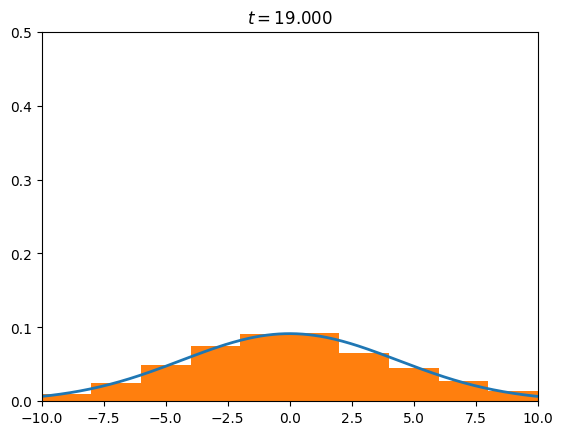

In [5]:
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython import display
from time import sleep

#Define parameters and x grid
N = 500
L = 20
num_timesteps = 20
x2 = np.linspace(-L, L, N)

# Diffusivity
D = 1/2

#Define initial condition (here we use a "thin" Gaussian to approximate a delta function)
Init = np.zeros(len(x2))
for k in range(0, len(x2)-2):
  Init[k] = np.exp(-x2[k]**2/(4*D*0.01)) / np.sqrt(4*D*math.pi*0.01)


#discretise the equations
def reaction_diffusion_ode(c, t):
    dy = np.zeros_like(c)
    h = x2[1] - x2[0]

    # Ghost point. No flux at x = 0
    c0 = c[1]
    dy[0] = D * (c[1] - 2*c[0] + c0) / (h**2)

    for k in range(1, len(c)-2):
        dy[k] = D * (c[k+1] - 2*c[k] + c[k-1]) / (h**2)

    # Ghost point. No flux at x = 1
    cend = c[len(c)-2]
    dy[len(c)-1] = D * (cend - 2*c[len(c)-1] + c[len(c)-2]) / (h**2)

    return dy

#Solve discretised equations using a scipy ODE solver (odeint)
options = {'rtol': 1e-10, 'atol': 1e-10}
t = np.linspace(0, num_timesteps, num_timesteps+1)
c = odeint(reaction_diffusion_ode, Init, t, args=())

#Plot the solution in comparison to the histogram of random walkers, which was calculated above
fig, ax = plt.subplots()
for j in range(0,num_timesteps):
  ax.clear()
  ax.plot(x2, c[j,:], linewidth=2)
  title_str = '$t = {:.3f}$'.format(t[j])
  ax.set_title(title_str)
  ax.set_xlim(-10, 10)
  ax.set_ylim(0, 0.5)
  plt.hist(position[j,:],bins,density=True)
  display.display(plt.gcf())
  display.clear_output(wait=True)
  sleep(0.01)


Finally, we compare all three solutions at a single time point.

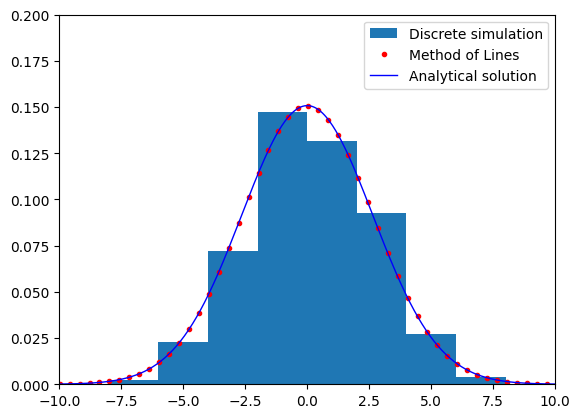

In [9]:
#Compare analytical solution, method of lines solution, and histogram at a single time point
fig, ax = plt.subplots()
plt.hist(position[7,:],bins,density=True,label='Discrete simulation')
plt.plot(x2[0:N:5], c[7,0:N:5],'.',color ='red',linewidth=1,label='Method of Lines')
ax.set_xlim(-10, 10)
ax.set_ylim(0, 0.2)
plt.plot(x,y[7,:],color='blue',linewidth=1,label='Analytical solution')
legend = ax.legend(loc='upper right')